In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from graphmodels.database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd
import numpy as np
from models.Hermen.model_BE2 import BE2_models

In [3]:
#fbs_data = select_dataset('foodbalancesheet')
fbs_data = select_dataset('foodbalancesheet_new')

population_data = select_dataset('population')
crops_data = select_dataset('crops')
landuse = select_dataset('landuse')
corrected_cl = pd.read_csv('outputs/cl_corr.csv')

In [4]:
model_df = pd.concat([fbs_data, population_data, crops_data],).dropna(subset=['Variable'])
model_df = model_df[~model_df.Variable.isin(['Domestic supply quantity'])]

In [5]:
test = model_df.query('Year > 2014').drop(columns=['group', 'Description', 'Unit'])

In [6]:
test.to_csv('outputs/BE2_df.csv', index=False)

In [7]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    
    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))


    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
    ]

#data_dict = df_to_data_dict(model_df, itemized)
data_dict = df_to_data_dict(test, itemized)

data_dict.update(df_to_data_dict(landuse, itemized=[]))

data_dict['CL_baseline'] = data_dict['CL']
data_dict['IL_baseline'] = data_dict['IL']
data_dict['FL_baseline'] = data_dict['FL']
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)


#data_dict['CL_corr_intercept'] = corrected_cl.query('name != "comp"').rename(columns={"name": 'ISO'}).set_index('ISO')['coef']
#data_dict['CL_corr_coef'] = pd.Series(data=corrected_cl.query('name == "comp"')['coef'].values[0], index=data_dict['CL_corr_intercept'].index)
data_dict['CL_corr_coef'] = 0.7

data_dict['CYi'] = data_dict['CYi'].replace(0, np.nan)

In [8]:
ISO_data_dict = {k: v.loc[['FRA', 'HUN', 'DEU', 'NLD', 'BEL', 'CHE', 'BRA', 'SEN'], [2016, 2017, 2018], :] for k, v in data_dict.items() if k not in ['CL_corr_coef']}
ISO_data_dict['CL_corr_coef'] = 1.4

In [9]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['FPi_model'], ISO_data_dict)


res = BE2_models['FPi_model'].run(X)
score_model(BE2_models['FPi_model'], X, y_true)

FPi


,r2,correlation,rmse,Variable
0,0.044052,0.211686,4.089113e+08,FPi


In [10]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['TCLDi_model'], ISO_data_dict)

res = BE2_models['TCLDi_model'].run(X)

score_model(BE2_models['TCLDi_model'], X, y_true)

FPi
TCLDi


,r2,correlation,rmse,Variable
0,0.044052,0.211686,4.089113e+08,FPi
1,0.221387,0.484529,8.646844e+12,TCLDi


In [11]:
plot_diagnostic(BE2_models['TCLDi_model'], X, y_true, 'FPi', hover_data=['Item'])

In [12]:
X, y_true = get_X_y_from_data(BE2_models['IL_FL_model'], ISO_data_dict)

score_model(BE2_models['IL_FL_model'], X, y_true)


IL
FL


,r2,correlation,rmse,Variable
0,1.0,1.0,0.0,IL
1,1.0,1.0,0.0,FL


In [13]:
X, y_true = get_X_y_from_data(BE2_models['BE2_model'], ISO_data_dict)
res = BE2_models['BE2_model'].run(X)
score_model(BE2_models['BE2_model'], X, y_true)

FL
IL
CL
TCLDi
FPi


,r2,correlation,rmse,Variable
0,0.996999,0.999990,8.038138e+07,FL
1,-5.329825,0.835806,4.779927e+05,IL
2,0.797699,0.995561,8.088528e+07,CL
3,0.221387,0.484529,8.646844e+12,TCLDi
4,0.044052,0.211686,4.089113e+08,FPi


In [14]:
plot_diagnostic(BE2_models['BE2_model'], X, y_true, 'CL', hover_data=['ISO'])

In [15]:
plot_diagnostic(BE2_models['BE2_model'], X, y_true, 'CL')

In [16]:
test = pd.concat([res['CL'], data_dict['CL']], axis=1)
test.columns = ['computation', 'baseline']
test = test[(test.computation != 0)].dropna()

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [18]:
encoder =  OneHotEncoder()
one_hot_ISO = encoder.fit_transform(test.reset_index()[['ISO']]).todense()
comp = test['computation'].values.reshape(-1, 1)

X = np.concatenate([one_hot_ISO, comp], axis=1)

In [19]:
lr = LinearRegression(fit_intercept=False).fit(X, test['baseline'])
lr.score(X, test['baseline'])

0.9999944360354677

In [20]:
correction_cl = pd.DataFrame({'coef': lr.coef_, 'name': list(encoder.categories_[0]) + ['comp']})
correction_cl.to_csv('outputs/cl_corr.csv')

In [21]:
data_dict['CL_corr_coef'] = correction_cl.query('name == "comp"')['coef'].values
data_dict['CL_corr_intercept'] = correction_cl.query('name != "comp"').rename(columns={"name": 'ISO'}).set_index('ISO')['coef']

In [22]:
corrected_cl = res['CL'] * data_dict['CL_corr_coef']  +  data_dict['CL_corr_intercept']

In [23]:
test['corr'] = lr.predict(X)

In [24]:
test.loc['DEU']

,computation,baseline,corr
Year,,,
2016,12202.583551,11962.0,11961.056318
2017,12200.430451,11971.0,11960.902548
2018,11922.329704,11930.0,11941.041134


In [25]:
import plotly.express as px

px.scatter(test.loc['FRA', :, :].reset_index(), y='computation', x='baseline', hover_data=['ISO', 'Year'])

In [26]:
import plotly.express as px

px.scatter(test.reset_index(), y='computation', x='baseline', hover_data=['ISO', 'Year'])

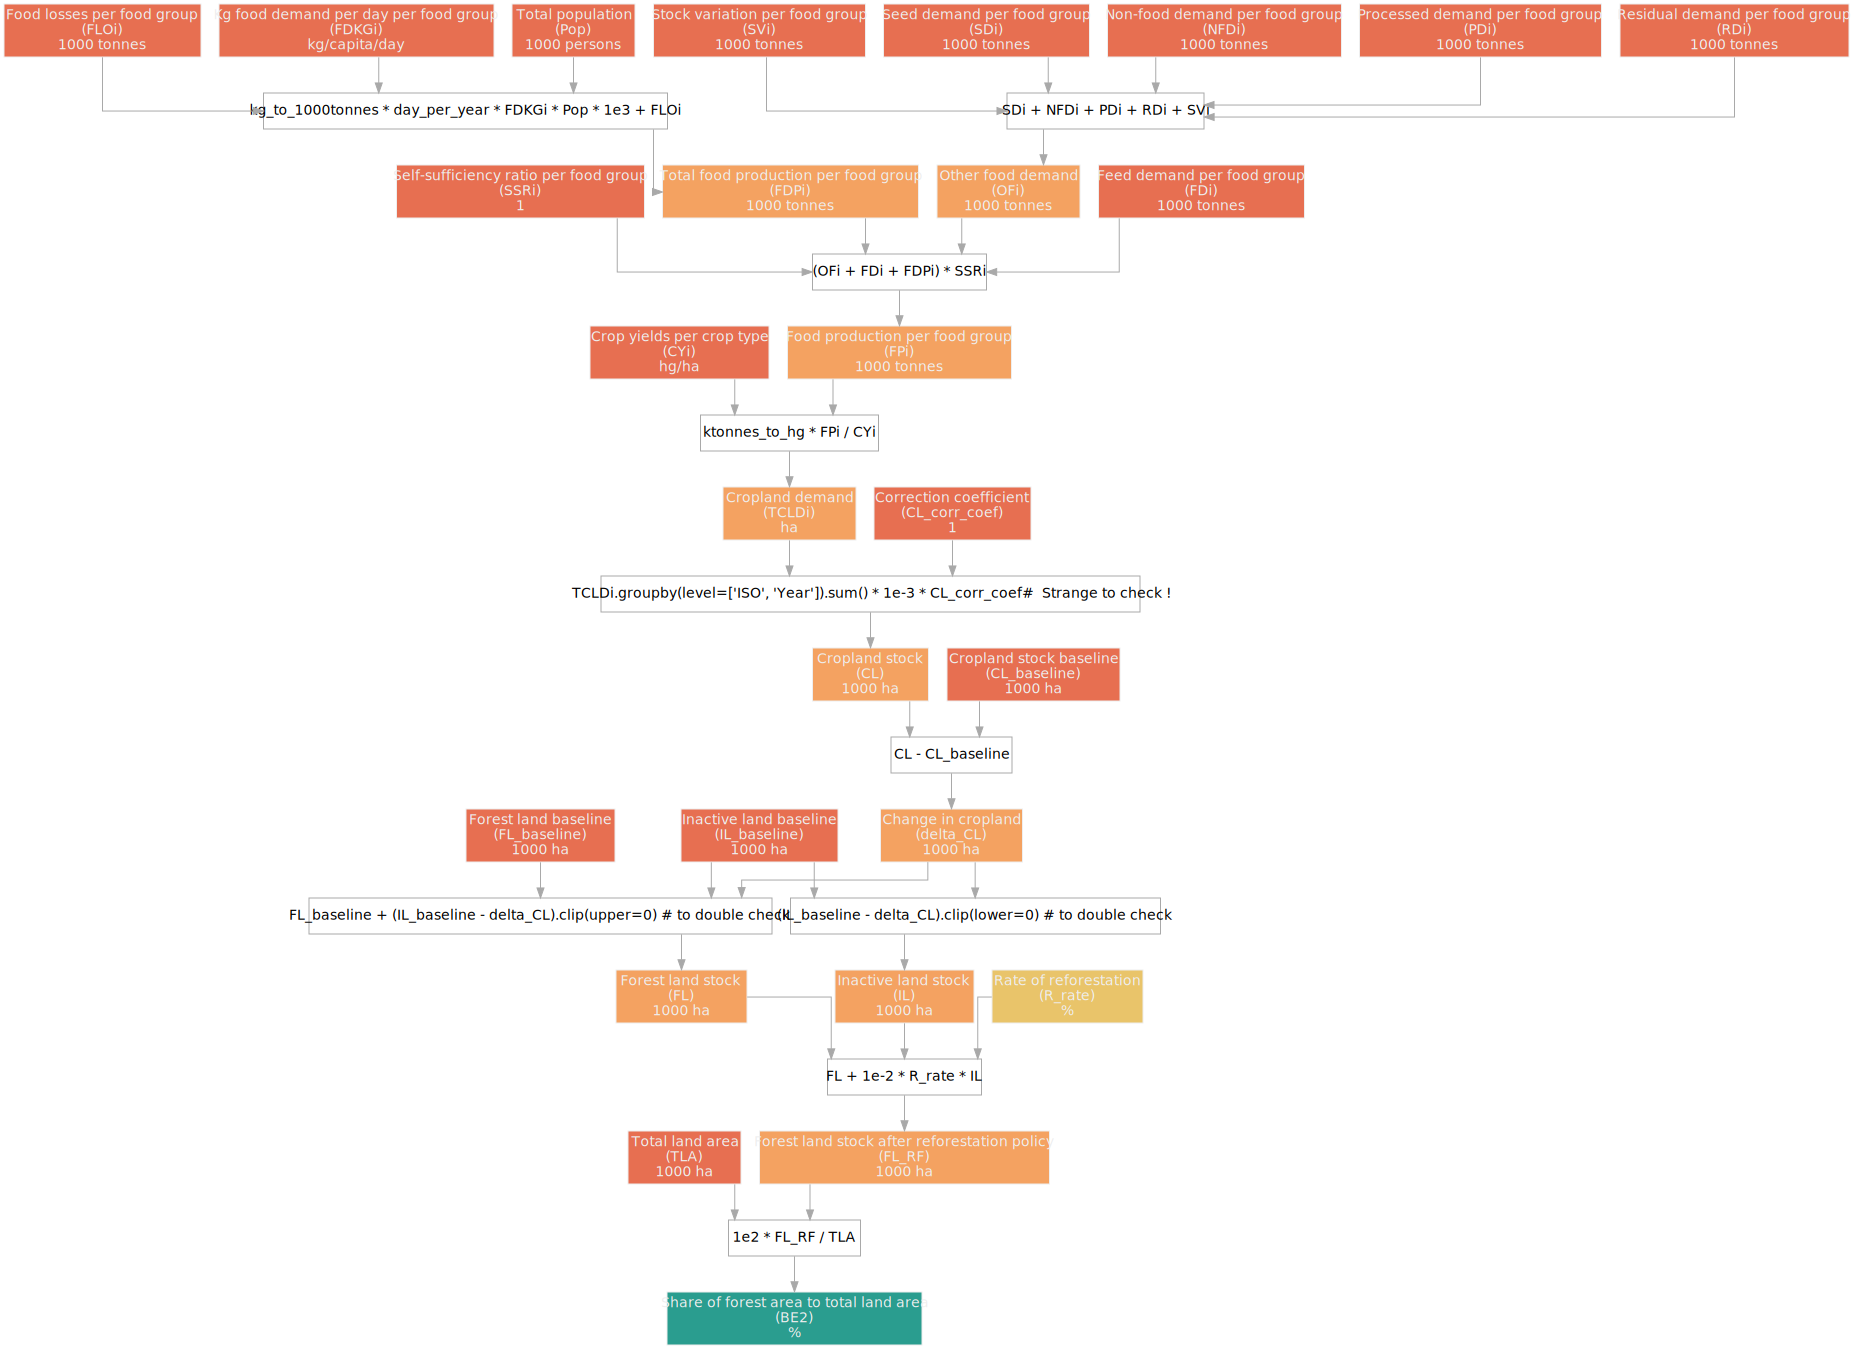

In [27]:
BE2_models['BE2_model'].draw()

# Assumptions 

- FLOi: user input, 2050 target +50 -50% baseline 
- FDKGi: user input, 1st idea a 2050 target +50 -50% baseline, interpolate in between same for everygroup. (Maybe see how to do to diet change later)
- Pop: projection
- OFi children: keep constant (maybe a regression later to have something more relevant)
- FDi: for now incomplete (FCRi in complete model maybe play with it, FCRi scenario: to check for now leave alone !). 
- SSRi : could stay constant, could be projected with pop, some increase somehow, let's see case by case (Might need some sort feedbackloop with landuse)
- CYi : user input, 2050 target ! (to look for realistic values)
- TLA: constant
- R_rate: User input, 


In [28]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values(
        'ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(
        2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values

    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series


def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2018:] = constant

    return series


def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)

    return series.groupby(['ISO']).fillna(method='ffill')


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)

    return results


def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict

In [29]:
%%time

ISO = 'FRA'
data_dict_filtered = {k: v.loc[ISO, 2000:] for k, v in data_dict.items()}
res = run_BE2_scenario(data_dict=run_BE2_projection(data_dict_filtered))


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
data_dict['FL'].loc['FRA', 2010:]

In [ ]:
res['FL_RF'].loc['FRA', 2010:]

In [ ]:
res['FL']

In [ ]:
model